2025-09-24 18:41:39.307 | INFO     | texas_gerrymandering_hb4.config:<module>:11 - PROJ_ROOT path is: /home/aimlexpert/Documents/GitHub/texas-gerrymandering-HB4


Geometry rows: 38 | Merged rows: 38
Null cluster_full: 0 | Null cluster_norace: 0


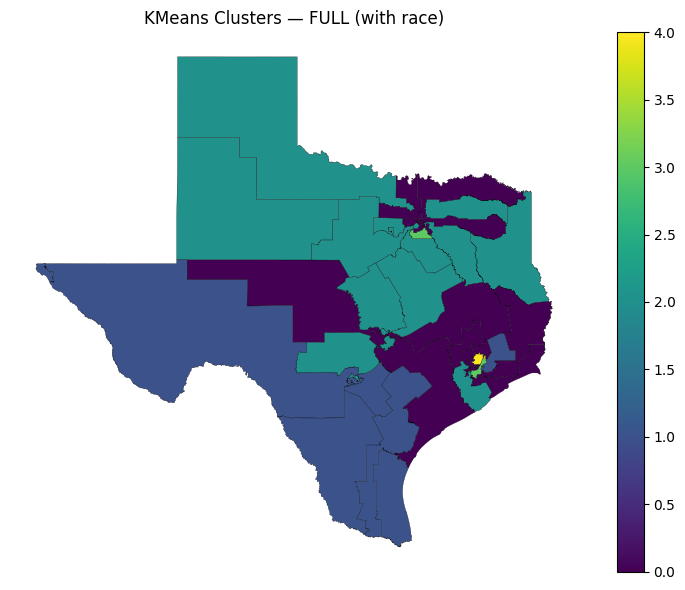

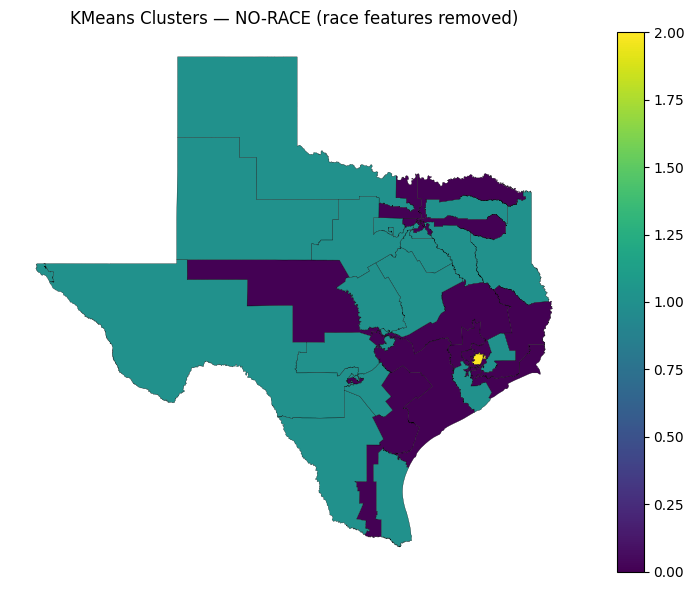

Saved GeoParquet: districts_with_clusters.parquet


In [1]:
# === CONFIG ===
ART_DIR = "artifacts"                 # where clusters_full.csv / clusters_norace.csv live (Mode A)
USE_MODE_A = True                     # True = use saved clusters, False = recompute k=3 here

ID_COL = "district_id"
RACE_COLS = ["pct_white","pct_black","pct_asian","pct_hispanic"]

# === IMPORTS ===
import os
import pandas as pd
import geopandas as gpd
from texas_gerrymandering_hb4.config import FINAL_CSV, CLEAN_DISTRICTS_PARQUET

# Optional imports for Mode B
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# === LOAD GEOMETRY (GeoParquet) ===
# Requires: geopandas>=0.12 and pyarrow>=10 (>=14 recommended)
gdf = gpd.read_parquet(CLEAN_DISTRICTS_PARQUET)

# Ensure we have a numeric district_id
if ID_COL not in gdf.columns:
    # Try common variants
    for cand in ["district", "districtid", "cd", "cd_id", "DISTRICT_ID", "District_ID"]:
        if cand in gdf.columns:
            gdf = gdf.rename(columns={cand: ID_COL})
            break
assert ID_COL in gdf.columns, f"'{ID_COL}' not found in geometry columns: {gdf.columns.tolist()}"
gdf[ID_COL] = pd.to_numeric(gdf[ID_COL], errors="raise")

# === LOAD/BUILD CLUSTERS ===
if USE_MODE_A and os.path.exists(f"{ART_DIR}/clusters_full.csv") and os.path.exists(f"{ART_DIR}/clusters_norace.csv"):
    cf = pd.read_csv(f"{ART_DIR}/clusters_full.csv")
    cn = pd.read_csv(f"{ART_DIR}/clusters_norace.csv")
    cf[ID_COL] = pd.to_numeric(cf[ID_COL], errors="raise")
    cn[ID_COL] = pd.to_numeric(cn[ID_COL], errors="raise")
else:
    # Mode B: recompute k=3 from the tabular dataset
    df = pd.read_csv(FINAL_CSV)
    df[ID_COL] = pd.to_numeric(df[ID_COL], errors="raise")

    # FULL = all features except id
    X_full = df.drop(columns=[ID_COL])
    X_full_s = StandardScaler().fit_transform(X_full)
    km_full = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_full_s)
    cf = df[[ID_COL]].copy()
    cf["cluster_full"] = km_full.labels_

    # NO-RACE = drop racial columns
    drop_cols = [c for c in RACE_COLS if c in df.columns]
    X_norace = df.drop(columns=[ID_COL] + drop_cols)
    X_norace_s = StandardScaler().fit_transform(X_norace)
    km_norace = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_norace_s)
    cn = df[[ID_COL]].copy()
    cn["cluster_norace"] = km_norace.labels_

# === MERGE CLUSTERS ONTO GEOMETRY ===
gmap = gdf.merge(cf, on=ID_COL, how="left").merge(cn, on=ID_COL, how="left")

print("Geometry rows:", len(gdf), "| Merged rows:", len(gmap))
print("Null cluster_full:", gmap['cluster_full'].isna().sum(),
      "| Null cluster_norace:", gmap['cluster_norace'].isna().sum())

# === QUICKLOOK MAPS (two separate figures) ===
import matplotlib.pyplot as plt

ax = gmap.plot(column="cluster_full", legend=True, linewidth=0.2, edgecolor="black", figsize=(8,6))
ax.set_title("KMeans Clusters — FULL (with race)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("districts_clusters_full.png", dpi=200)
plt.show()

ax = gmap.plot(column="cluster_norace", legend=True, linewidth=0.2, edgecolor="black", figsize=(8,6))
ax.set_title("KMeans Clusters — NO-RACE (race features removed)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("districts_clusters_norace.png", dpi=200)
plt.show()

# === EXPORT MERGED GEO DATASETS ===
# GeoParquet (fast & compact)
out_parquet = "districts_with_clusters.parquet"
gmap.to_parquet(out_parquet)
print("Saved GeoParquet:", out_parquet)

# Optional: GeoJSON for web mapping (comment out if you don't need it)
# out_geojson = "districts_with_clusters.geojson"
# gmap.to_file(out_geojson, driver="GeoJSON")
# print("Saved GeoJSON:", out_geojson)
